In [148]:
%matplotlib inline

# Introduction to Deep Learning with Keras and TensorFlow

**Daniel Moser (UT Southwestern Medical Center)**

**Resources: [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [149]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
import tensorflow as tf
import pydot
import graphviz

from tensorflow.keras.datasets import mnist     # MNIST dataset is included in Keras
from tensorflow.keras.models import Sequential  # Model type to be used

import ann_visualizer.visualize as ann_viz
from tensorflow.keras.layers import Dense, Dropout, Activation # Types of layers to be used in our model
from tensorflow.keras import utils as np_utils                         # NumPy related tools

import os
import datetime

## Visualization
TensorBoard will be used for visualization purposes

In [150]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [151]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

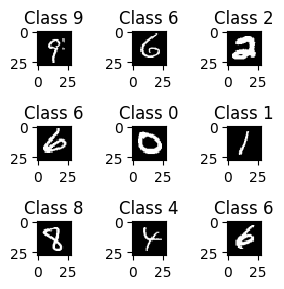

In [152]:
plt.rcParams['figure.figsize'] = (3,3) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [153]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
matprint(X_train[num])

0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    6  164  254  79  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    4   56  237  253  248  17  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0   90  253  253  197   65   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0  118  233  253  186   64    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    8   65  232  253  227   32    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0   81  253  253  1

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' style="width: 400px; height: 250px;">

In [154]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [155]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" style="width: 300px; height: 300px;"/>

In [163]:
# The Sequential model is a linear stack of layers and is very common.
model = Sequential()

<h3>Build Your Model</h3>
Bellow are attributes that you can edit to see if these improve or disimprove the model runs.

In [164]:
activation_function = 'swish'
dropout_perc = 0.2
batch_size = 128

# New layer
new_layers = True
neuron_nums = []


def build_model(activation_function,dropout_perc,new_layer,neuron_num):
    # The first hidden layer is a set of 512 nodes (artificial neurons).
    # Each node will receive an element from each input vector and apply some weight and bias to it.
    model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!
    
    # An "activation" is a non-linear function applied to the output of the layer above.
    # It checks the new value of the node, and decides whether that artifical neuron has fired.
    # The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
    # Those inputs are then not considered to be fired.
    # Positive values of a node are unchanged.
    model.add(Activation(activation_function))
    
    # Dropout zeroes a selection of random outputs (i.e., disables their activation)
    # Dropout helps protect the model from memorizing or "overfitting" the training data.
    model.add(Dropout(dropout_perc))
    
    # The following hidden layers appear identical to our first layer.
    # However, instead of each of the 512-node receiving 784-inputs from the input image data,
    # they receive previous outputs as inputs for themselves.    
    for num in neuron_nums:    
        model.add(Dense(num))
        model.add(Activation(activation_function))
        model.add(Dropout(dropout_perc))
    
    # The final layer of 10 neurons in fully-connected to the previous 512-node layer.
    # The final layer of a FCN should be equal to the number of desired classes (10 in this case).
    model.add(Dense(10))
    
    model.add(Activation('softmax'))


In [165]:
build_model(activation_function,dropout_perc,new_layers,neuron_nums)
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 512)               401920    
                                                                 
 activation_92 (Activation)  (None, 512)               0         
                                                                 
 dropout_67 (Dropout)        (None, 512)               0         
                                                                 
 dense_89 (Dense)            (None, 10)                5130      
                                                                 
 activation_93 (Activation)  (None, 10)                0         
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


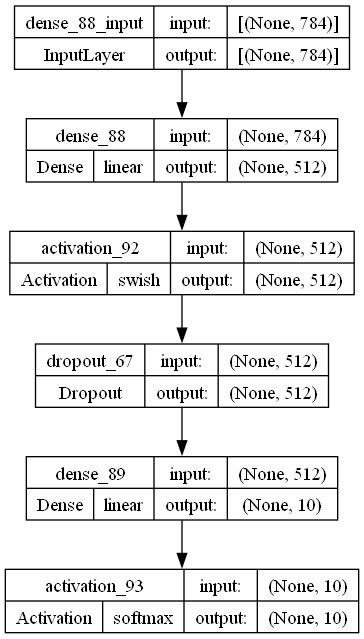

In [166]:
np_utils.plot_model(model, to_file="MNIST_model.png", show_shapes=True, show_layer_activations=True)

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

<img src = "./gradient_descent.png" style="width: 400px; height: 200px">

<img src = "./learning_rate.png" style="width: 400px; height: 200px;">

<p>So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.</p>

<img src = './complicated_loss_function.png' style="width: 400px; height: 200px;">

In [167]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model!
This is the fun part!

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [168]:
model.fit(X_train, Y_train,
          batch_size=batch_size, epochs=5,
          verbose=1)

Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3166 - accuracy: 0.9096
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1413 - accuracy: 0.9586
Epoch 3/5
469/469 [==============================] - 5s 12ms/step - loss: 0.0959 - accuracy: 0.9717
Epoch 4/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0710 - accuracy: 0.9788
Epoch 5/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0557 - accuracy: 0.9825


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [162]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0768 - accuracy: 0.9782
Test score: 0.07678145170211792
Test accuracy: 0.9782000184059143


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [23]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(np.argmax(predicted_classes, axis=1) == y_test)[0]
incorrect_indices = np.nonzero(np.argmax(predicted_classes, axis=1) != y_test)[0]


313/313 [==============================] - 2s 5ms/step


In [24]:
print(correct_indices, incorrect_indices)

[   0    1    2 ... 9997 9998 9999] [ 149  151  217  247  259  324  381  445  447  450  582  610  619  646
  691  720  740  844  900  938  947  951 1014 1039 1044 1112 1114 1156
 1166 1181 1182 1192 1208 1226 1232 1247 1260 1299 1319 1328 1393 1414
 1444 1494 1522 1530 1531 1549 1553 1607 1609 1640 1681 1721 1732 1754
 1790 1878 1901 1941 2016 2024 2043 2053 2070 2098 2109 2118 2129 2130
 2135 2182 2185 2189 2272 2293 2325 2369 2387 2405 2406 2408 2414 2433
 2454 2488 2582 2607 2648 2654 2720 2743 2863 2896 2921 2927 2939 2952
 2953 2995 3030 3073 3108 3114 3117 3157 3225 3284 3333 3384 3405 3422
 3503 3520 3542 3549 3597 3604 3751 3767 3776 3780 3808 3811 3906 3941
 3943 3962 3976 4007 4027 4065 4075 4078 4163 4176 4199 4211 4224 4248
 4294 4317 4400 4433 4477 4487 4497 4500 4536 4552 4558 4635 4639 4740
 4807 4814 4823 4833 4860 4879 4880 4950 4966 4990 5331 5457 5676 5749
 5842 5887 5888 5936 5955 5973 6023 6035 6045 6059 6065 6101 6166 6173
 6174 6542 6555 6560 6571 6572 6576 6597 

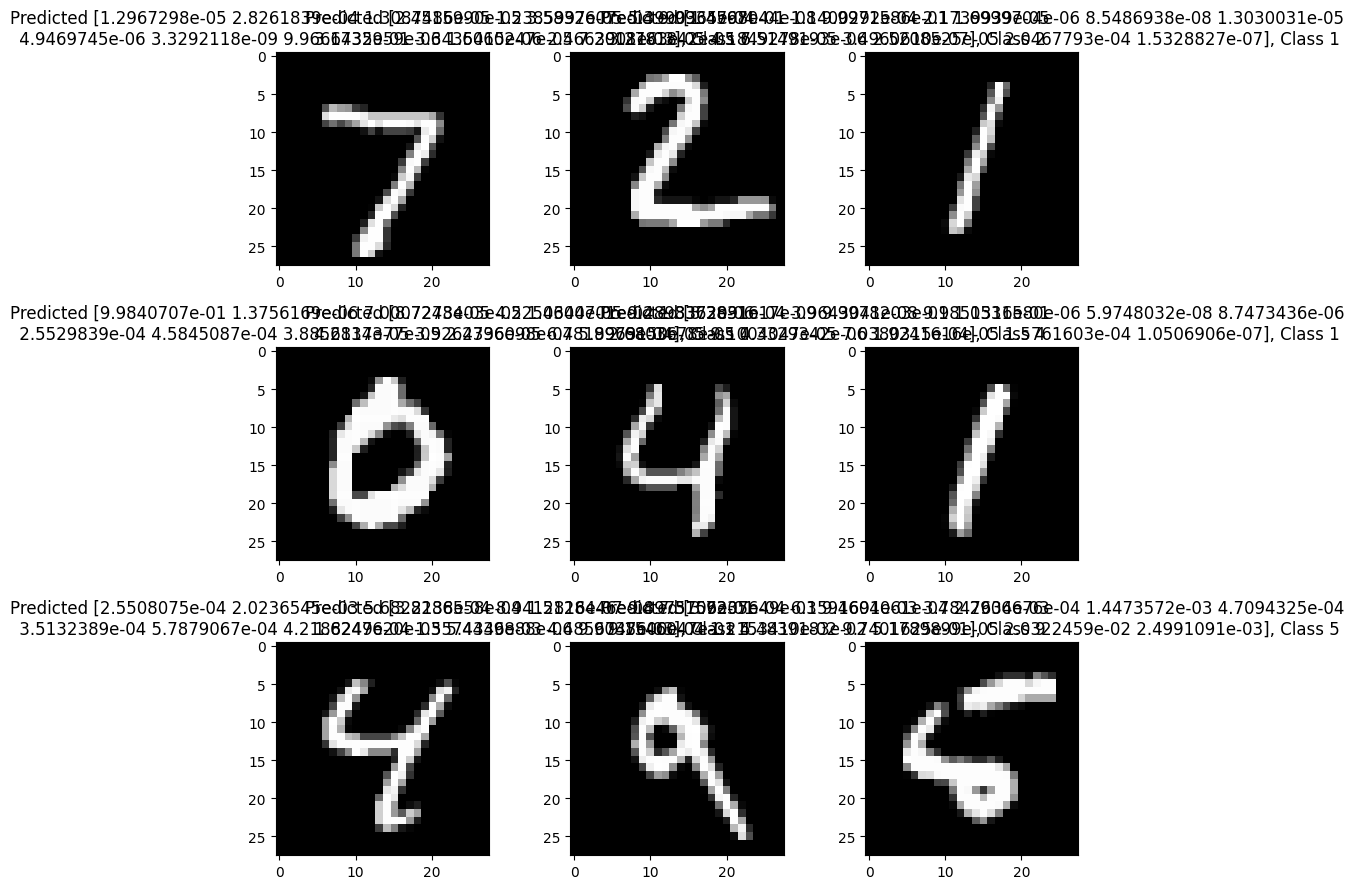

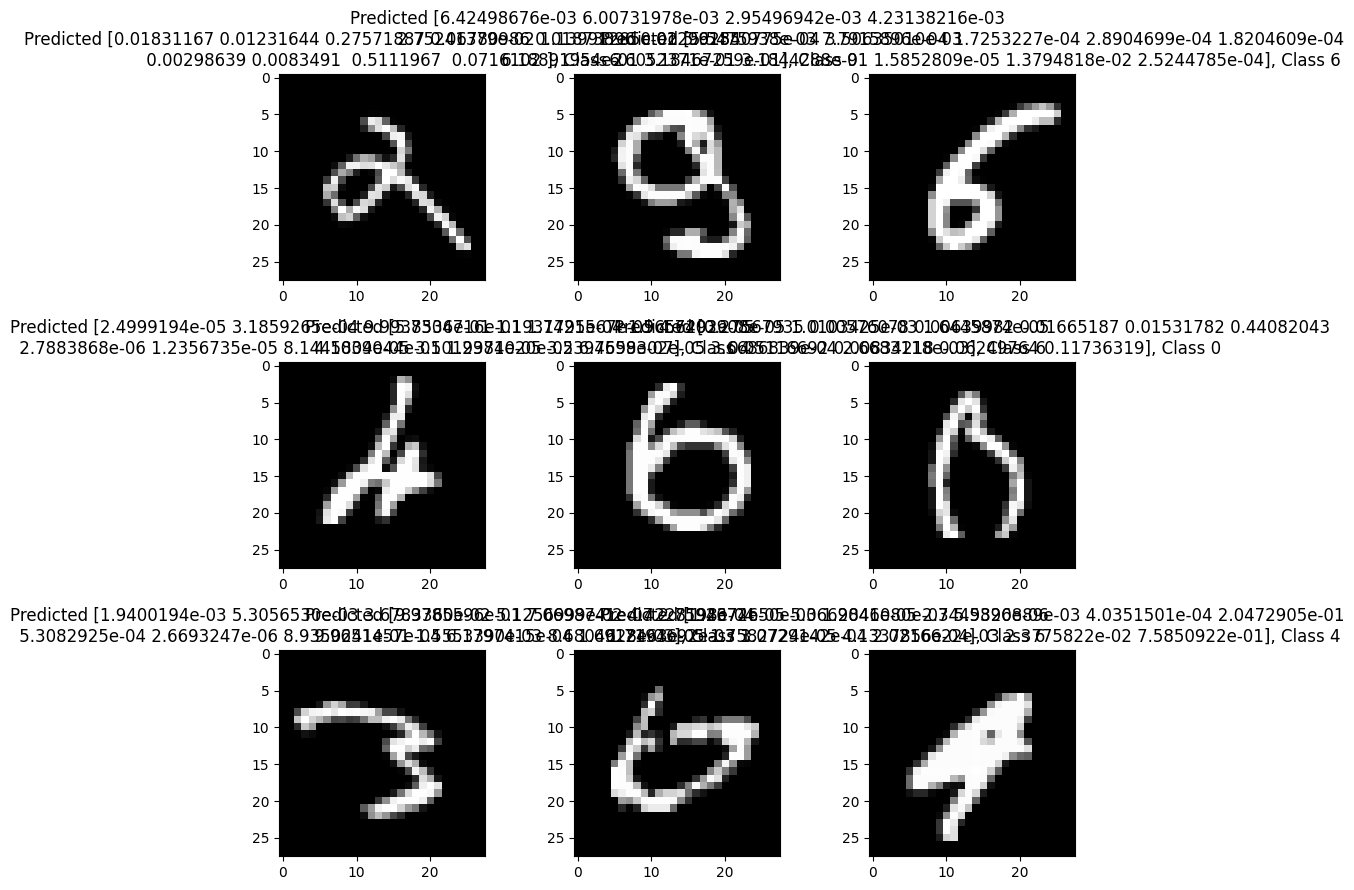

In [25]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.tight_layout()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

plt.tight_layout()